In [84]:
import torch
from torch import nn
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import pil_to_tensor
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from timeit import default_timer as timer
from PIL import Image
import random
from tqdm.auto import tqdm
import torchinfo
from torchinfo import summary
import os
import cv2
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%config InlineBackend.figure_format = "svg"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.__version__)
print(torchvision.__version__)
print(f"Using device:{device}")
print(f"Using {torch.cuda.get_device_name()}")

2.1.2+cu118
0.16.2+cu118
Using device:cuda
Using NVIDIA GeForce GTX 1650 Ti


In [86]:
# class CustomMRTestDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.image_paths = self._get_image_paths()

#     def _get_image_paths(self):
#         image_paths = []
#         for file_name in os.listdir(self.root_dir):
#             if file_name.endswith('.jpeg'):
#                 image_paths.append(os.path.join(self.root_dir, file_name))
#         return image_paths

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         image = Image.open(img_path).convert("L")  # Ensure that images are RGB (not grayscale)
#         if self.transform:
#             image = self.transform(image)
#         return image

# # Define data transformations
# transform = transforms.Compose([
#     # transforms.Resize((256, 256)),
#     transforms.ToTensor(),
# ])

# # Create custom dataset
# test_dataset = CustomMRTestDataset(root_dir='MR_test', transform=transform)
# len(test_dataset)

In [87]:
def reassign_values(img):
    new_img = torch.zeros_like(img)
    new_img[(img >= 55) & (img <= 70)] = 1
    new_img[(img >= 110) & (img <= 135)] = 2
    new_img[(img >= 175) & (img <= 200)] = 3
    new_img[(img >= 240) & (img <= 255)] = 4
    return new_img.type(torch.uint8)

class CustomMRDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpeg')]
        self.label_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.image_files.sort()
        self.label_files.sort()
        assert len(self.image_files) == len(self.label_files), "Number of images and labels must match"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        label_name = os.path.join(self.root_dir, self.label_files[idx])
        
        # Load image and label
        image = Image.open(img_name).convert("L")
        label = Image.open(label_name).convert("L")

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
            label = (label*255).type(torch.uint8)
            label = reassign_values(label)
            
        return image, label

# Example usage:
# Define transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

# Create custom dataset
custom_dataset = CustomMRDataset(root_dir="MR_train", transform=transform)
class_names = {0:"background",1:"liver",2:"right kidney",3:"left kidney",4:"spleen"}

train_size = int(0.9 * len(custom_dataset))  # 80% of the data for training
val_size = len(custom_dataset) - train_size  # Remaining 20% for validation
# Split the dataset
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

# Print the number of samples in the train dataset
print("Number of samples in the train dataset:", len(train_dataset))
print("Number of samples in the validation dataset:", len(val_dataset))

Number of samples in the train dataset: 560
Number of samples in the validation dataset: 63


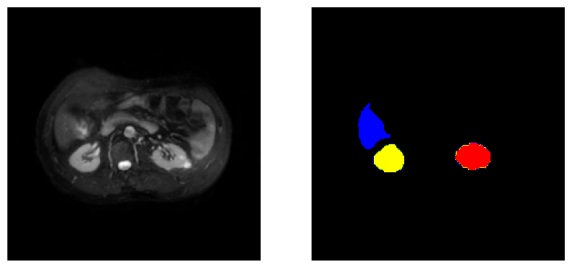

(torch.Size([1, 224, 224]), torch.Size([1, 224, 224]))

In [286]:
random_idx = torch.randint(0, len(train_dataset), size = [1,]).item()
colors = colors = ['black', 'blue', 'green', 'yellow', 'red']
cmap = plt.matplotlib.colors.ListedColormap(colors)
img,mask = train_dataset[random_idx]
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(img.squeeze(), cmap = "gray")
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(mask.squeeze(), cmap = cmap)
plt.axis(False)
plt.show()
img.shape, mask.shape

In [235]:
torch.unique(mask)

tensor([0, 1, 2, 3], dtype=torch.uint8)

In [90]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [91]:
class scSE(nn.Module):
    def __init__(self, in_channels, r = 2):
        super(scSE, self).__init__()
        mid_channels = in_channels//r
        self.cSE = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(mid_channels, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.sSE = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = 1, kernel_size = 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Take mean over H and W dimensions
        mean_tensor = torch.mean(x, dim=[2, 3], keepdim=True)
        channel_scaling = self.cSE(mean_tensor).expand(-1, -1, x.size(2), x.size(3))
        u_cSE = x*channel_scaling
        spatial_scaling = self.sSE(x).expand(-1, x.size(1), -1, -1)
        u_sSE = x*spatial_scaling
        return torch.maximum(u_sSE,u_cSE)

In [92]:
class SegNet(nn.Module):

    def __init__(self, in_chn=3, out_chn=32, BN_momentum=0.5):
        super(SegNet, self).__init__()

        #SegNet Architecture
        #Takes input of size in_chn = 3 (RGB images have 3 channels)
        #Outputs size label_chn (N # of classes)

        #ENCODING consists of 5 stages
        #Stage 1, 2 has 2 layers of Convolution + Batch Normalization + Max Pool respectively
        #Stage 3, 4, 5 has 3 layers of Convolution + Batch Normalization + Max Pool respectively

        #General Max Pool 2D for ENCODING layers
        #Pooling indices are stored for Upsampling in DECODING layers

        self.in_chn = in_chn
        self.out_chn = out_chn

        self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True) 

        self.ConvEn11 = nn.Conv2d(self.in_chn, 16, kernel_size=3, padding=1)
        self.BNEn11 = nn.BatchNorm2d(16, momentum=BN_momentum)
        self.ConvEn12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(16, momentum=BN_momentum)

        self.ConvEn21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.BNEn21 = nn.BatchNorm2d(32, momentum=BN_momentum)
        self.ConvEn22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(32, momentum=BN_momentum)

        self.ConvEn31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.BNEn31 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn32 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvEn41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BNEn41 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn42 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvEn51 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn51 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn52 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn52 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn53 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(128, momentum=BN_momentum)


        #DECODING consists of 5 stages
        #Each stage corresponds to their respective counterparts in ENCODING

        #General Max Pool 2D/Upsampling for DECODING layers
        self.MaxDe = nn.MaxUnpool2d(2, stride=2) 

        self.ConvDe53 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe53 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe52 = nn.Conv2d(128,128, kernel_size=3, padding=1)
        self.BNDe52 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe51 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe51 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvDe43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe43 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe42 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe41 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvDe33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe33 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe32 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe31 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.BNDe31 = nn.BatchNorm2d(32, momentum=BN_momentum)

        self.ConvDe22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.BNDe22 = nn.BatchNorm2d(32, momentum=BN_momentum)
        self.ConvDe21 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.BNDe21 = nn.BatchNorm2d(16, momentum=BN_momentum)

        self.ConvDe12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.BNDe12 = nn.BatchNorm2d(16, momentum=BN_momentum)
        self.ConvDe11 = nn.Conv2d(16, self.out_chn, kernel_size=3, padding=1)
        self.BNDe11 = nn.BatchNorm2d(self.out_chn, momentum=BN_momentum)

    def forward(self, x):

        #ENCODE LAYERS
        #Stage 1
        x = F.relu(self.BNEn11(self.ConvEn11(x))) 
        x = F.relu(self.BNEn12(self.ConvEn12(x))) 
        x, ind1 = self.MaxEn(x)
        size1 = x.size()

        #Stage 2
        x = F.relu(self.BNEn21(self.ConvEn21(x))) 
        x = F.relu(self.BNEn22(self.ConvEn22(x))) 
        x, ind2 = self.MaxEn(x)
        size2 = x.size()

        #Stage 3
        x = F.relu(self.BNEn31(self.ConvEn31(x))) 
        x = F.relu(self.BNEn32(self.ConvEn32(x))) 
        x = F.relu(self.BNEn33(self.ConvEn33(x)))   
        x, ind3 = self.MaxEn(x)
        size3 = x.size()

        #Stage 4
        x = F.relu(self.BNEn41(self.ConvEn41(x))) 
        x = F.relu(self.BNEn42(self.ConvEn42(x))) 
        x = F.relu(self.BNEn43(self.ConvEn43(x)))   
        x, ind4 = self.MaxEn(x)
        size4 = x.size()

        #Stage 5
        x = F.relu(self.BNEn51(self.ConvEn51(x))) 
        x = F.relu(self.BNEn52(self.ConvEn52(x))) 
        x = F.relu(self.BNEn53(self.ConvEn53(x)))   
        # x, ind5 = self.MaxEn(x)
        size5 = x.size()

        #DECODE LAYERS
        #Stage 5
        # x = self.MaxDe(x, ind5, output_size=size4)
        x = F.relu(self.BNDe53(self.ConvDe53(x)))
        x = F.relu(self.BNDe52(self.ConvDe52(x)))
        x = F.relu(self.BNDe51(self.ConvDe51(x)))

        #Stage 4
        x = self.MaxDe(x, ind4, output_size=size3)
        x = F.relu(self.BNDe43(self.ConvDe43(x)))
        x = F.relu(self.BNDe42(self.ConvDe42(x)))
        x = F.relu(self.BNDe41(self.ConvDe41(x)))

        #Stage 3
        x = self.MaxDe(x, ind3, output_size=size2)
        x = F.relu(self.BNDe33(self.ConvDe33(x)))
        x = F.relu(self.BNDe32(self.ConvDe32(x)))
        x = F.relu(self.BNDe31(self.ConvDe31(x)))

        #Stage 2
        x = self.MaxDe(x, ind2, output_size=size1)
        x = F.relu(self.BNDe22(self.ConvDe22(x)))
        x = F.relu(self.BNDe21(self.ConvDe21(x)))

        #Stage 1
        x = self.MaxDe(x, ind1)
        x = F.relu(self.BNDe12(self.ConvDe12(x)))
        x = self.ConvDe11(x)

        return x

In [93]:
class SESegNet(nn.Module):

    def __init__(self, in_chn=3, out_chn=32, BN_momentum=0.5):
        super(SESegNet, self).__init__()

        #SegNet Architecture
        #Takes input of size in_chn = 3 (RGB images have 3 channels)
        #Outputs size label_chn (N # of classes)

        #ENCODING consists of 5 stages
        #Stage 1, 2 has 2 layers of Convolution + Batch Normalization + Max Pool respectively
        #Stage 3, 4, 5 has 3 layers of Convolution + Batch Normalization + Max Pool respectively

        #General Max Pool 2D for ENCODING layers
        #Pooling indices are stored for Upsampling in DECODING layers

        self.in_chn = in_chn
        self.out_chn = out_chn

        self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True) 

        self.ConvEn11 = nn.Conv2d(self.in_chn, 16, kernel_size=3, padding=1)
        self.BNEn11 = nn.BatchNorm2d(16, momentum=BN_momentum)
        self.ConvEn12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(16, momentum=BN_momentum)
        self.SE1 = scSE(16)

        self.ConvEn21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.BNEn21 = nn.BatchNorm2d(32, momentum=BN_momentum)
        self.ConvEn22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(32, momentum=BN_momentum)
        self.SE2 = scSE(32)

        self.ConvEn31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.BNEn31 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn32 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.SE3 = scSE(64)

        self.ConvEn41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BNEn41 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn42 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.SE4 = scSE(128)

        self.ConvEn51 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn51 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn52 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn52 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn53 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.SE5 = scSE(128)


        #DECODING consists of 5 stages
        #Each stage corresponds to their respective counterparts in ENCODING

        #General Max Pool 2D/Upsampling for DECODING layers
        self.MaxDe = nn.MaxUnpool2d(2, stride=2) 

        self.ConvDe53 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe53 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe52 = nn.Conv2d(128,128, kernel_size=3, padding=1)
        self.BNDe52 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe51 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe51 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.SE6 = scSE(128)

        self.ConvDe43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe43 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe42 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe41 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.SE7 = scSE(64)

        self.ConvDe33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe33 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe32 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe31 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.BNDe31 = nn.BatchNorm2d(32, momentum=BN_momentum)
        self.SE8 = scSE(32)

        self.ConvDe22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.BNDe22 = nn.BatchNorm2d(32, momentum=BN_momentum)
        self.ConvDe21 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.BNDe21 = nn.BatchNorm2d(16, momentum=BN_momentum)
        self.SE9 = scSE(16)

        self.ConvDe12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.BNDe12 = nn.BatchNorm2d(16, momentum=BN_momentum)
        self.ConvDe11 = nn.Conv2d(16, self.out_chn, kernel_size=3, padding=1)
        self.BNDe11 = nn.BatchNorm2d(self.out_chn, momentum=BN_momentum)

    def forward(self, x):

        #ENCODE LAYERS
        #Stage 1
        x = F.relu(self.BNEn11(self.ConvEn11(x))) 
        x = F.relu(self.BNEn12(self.ConvEn12(x))) 
        x, ind1 = self.MaxEn(x)
        x = self.SE1(x)
        size1 = x.size()

        #Stage 2
        x = F.relu(self.BNEn21(self.ConvEn21(x))) 
        x = F.relu(self.BNEn22(self.ConvEn22(x))) 
        x, ind2 = self.MaxEn(x)
        x = self.SE2(x)
        size2 = x.size()

        #Stage 3
        x = F.relu(self.BNEn31(self.ConvEn31(x))) 
        x = F.relu(self.BNEn32(self.ConvEn32(x))) 
        x = F.relu(self.BNEn33(self.ConvEn33(x)))   
        x, ind3 = self.MaxEn(x)
        x = self.SE3(x)
        size3 = x.size()

        #Stage 4
        x = F.relu(self.BNEn41(self.ConvEn41(x))) 
        x = F.relu(self.BNEn42(self.ConvEn42(x))) 
        x = F.relu(self.BNEn43(self.ConvEn43(x)))   
        x, ind4 = self.MaxEn(x)
        x = self.SE4(x)
        size4 = x.size()

        #Stage 5
        x = F.relu(self.BNEn51(self.ConvEn51(x))) 
        x = F.relu(self.BNEn52(self.ConvEn52(x))) 
        x = F.relu(self.BNEn53(self.ConvEn53(x)))   
        # x, ind5 = self.MaxEn(x)
        x = self.SE5(x)
        size5 = x.size()

        #DECODE LAYERS
        #Stage 5
        # x = self.MaxDe(x, ind5, output_size=size4)
        x = F.relu(self.BNDe53(self.ConvDe53(x)))
        x = F.relu(self.BNDe52(self.ConvDe52(x)))
        x = F.relu(self.BNDe51(self.ConvDe51(x)))
        x = self.SE6(x)

        #Stage 4
        x = self.MaxDe(x, ind4, output_size=size3)
        x = F.relu(self.BNDe43(self.ConvDe43(x)))
        x = F.relu(self.BNDe42(self.ConvDe42(x)))
        x = F.relu(self.BNDe41(self.ConvDe41(x)))
        x = self.SE7(x)

        #Stage 3
        x = self.MaxDe(x, ind3, output_size=size2)
        x = F.relu(self.BNDe33(self.ConvDe33(x)))
        x = F.relu(self.BNDe32(self.ConvDe32(x)))
        x = F.relu(self.BNDe31(self.ConvDe31(x)))
        x = self.SE8(x)

        #Stage 2
        x = self.MaxDe(x, ind2, output_size=size1)
        x = F.relu(self.BNDe22(self.ConvDe22(x)))
        x = F.relu(self.BNDe21(self.ConvDe21(x)))
        x = self.SE9(x)

        #Stage 1
        x = self.MaxDe(x, ind1)
        x = F.relu(self.BNDe12(self.ConvDe12(x)))
        x = self.ConvDe11(x)

        return x

In [94]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        # self.SE1 = scSE(16)
        # self.SE2 = scSE(32)
        # self.SE3 = scSE(64)
        # self.SE4 = scSE(128)
        # self.SE5 = scSE(64)
        # self.SE6 = scSE(32)
        # self.SE7 = scSE(16)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, self.n_classes)

    def forward(self, x):
        # x1 = self.SE1(self.inc(x))
        # x2 = self.SE2(self.down1(x1))
        # x3 = self.SE3(self.down2(x2))
        # x4 = self.SE4(self.down3(x3))
        # x5 = self.down4(x4)
        # x = self.SE5(self.up1(x5, x4))
        # x = self.SE6(self.up2(x, x3))
        # x = self.SE7(self.up3(x, x2))

        x1 = (self.inc(x))
        x2 = (self.down1(x1))
        x3 = (self.down2(x2))
        x4 = (self.down3(x3))
        x5 = self.down4(x4)
        x = (self.up1(x5, x4))
        x = (self.up2(x, x3))
        x = (self.up3(x, x2))
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [131]:
class SEUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SEUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.SE1 = scSE(16)
        self.SE2 = scSE(32)
        self.SE3 = scSE(64)
        self.SE4 = scSE(128)
        self.SE5 = scSE(64)
        self.SE6 = scSE(32)
        self.SE7 = scSE(16)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, self.n_classes)

    def forward(self, x):
        x1 = self.SE1(self.inc(x))
        x2 = self.SE2(self.down1(x1))
        x3 = self.SE3(self.down2(x2))
        x4 = self.SE4(self.down3(x3))
        x5 = self.down4(x4)
        x = self.SE5(self.up1(x5, x4))
        x = self.SE6(self.up2(x, x3))
        x = self.SE7(self.up3(x, x2))

        # x1 = (self.inc(x))
        # x2 = (self.down1(x1))
        # x3 = (self.down2(x2))
        # x4 = (self.down3(x3))
        # x5 = self.down4(x4)
        # x = (self.up1(x5, x4))
        # x = (self.up2(x, x3))
        # x = (self.up3(x, x2))
        
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [132]:
n_channels = 1
n_classes = 5
# model = SegNet(in_chn = 1, out_chn = 5).to(device)
model = SEUNet(n_channels = n_channels, n_classes = n_classes, bilinear = True)
summary(model, input_size = [8,1,512,512])

Layer (type:depth-idx)                        Output Shape              Param #
SEUNet                                        [8, 5, 512, 512]          --
├─DoubleConv: 1-1                             [8, 16, 512, 512]         --
│    └─Sequential: 2-1                        [8, 16, 512, 512]         --
│    │    └─Conv2d: 3-1                       [8, 16, 512, 512]         160
│    │    └─BatchNorm2d: 3-2                  [8, 16, 512, 512]         32
│    │    └─ReLU: 3-3                         [8, 16, 512, 512]         --
│    │    └─Conv2d: 3-4                       [8, 16, 512, 512]         2,320
│    │    └─BatchNorm2d: 3-5                  [8, 16, 512, 512]         32
│    │    └─ReLU: 3-6                         [8, 16, 512, 512]         --
├─scSE: 1-2                                   [8, 16, 512, 512]         --
│    └─Sequential: 2-2                        [8, 16, 1, 1]             --
│    │    └─Conv2d: 3-7                       [8, 8, 1, 1]              136
│    │    └─ReL

In [133]:
# def calculate_class_weights(dataset):
#     # Initialize counters for each class
#     class_counts = {0:0,1:0,2:0,3:0,4:0}
    
#     # Iterate through the dataset to count pixel occurrences
#     for _, labels in tqdm(dataset):
#         # Flatten the label tensor and count occurrences
#         unique, counts = torch.unique(labels, return_counts=True)
#         for i,value in enumerate(unique):
#             class_counts[value.item()] +=counts[i]
    
#     # Calculate inverse frequencies
#     class_freq = np.zeros((5,))
#     total = 0
#     for i in range(5):
#         class_freq[i] = class_counts[i]
#         total = total + class_counts[i]
        
#     class_weights = total/class_freq
#     class_weights = class_weights/torch.sum(class_weights)

#     return class_weights.float()

# # Example usage:
# class_weights = calculate_class_weights(train_dataset)
# print("Class Weights:", class_weights)
# class_weights = class_weights.to(device)
# class_weights

In [134]:
def jaccard_coefficient(prediction, target, class_index):
    smooth = 1e-7
    prediction = prediction == class_index
    target = target == class_index

    intersection = torch.sum(prediction & target).item()
    union = torch.sum(prediction | target).item()

    jaccard_score = (intersection + smooth) / (union + smooth)
    return jaccard_score

def compute_average_jaccard_coefficient(model, dataset, num_classes):
    model.eval()
    class_jaccard_scores = np.zeros(num_classes)
    with torch.inference_mode():
        for inputs, targets in tqdm(dataset):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs.unsqueeze(0)).squeeze().argmax(dim = 0)

            for class_index in range(num_classes):
                class_jaccard_scores[class_index] += jaccard_coefficient(outputs, targets, class_index)

    average_jaccard_scores = class_jaccard_scores / len(dataset)
    return average_jaccard_scores

In [135]:
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.weight = weight

    def forward(self, logits, labels):
        # Reshape logits to [batch_size * height * width, num_classes]
        logits_flat = logits.permute(0, 2, 3, 1).contiguous().view(-1, logits.shape[1])
        
        # Reshape labels to [batch_size * height * width]
        labels_flat = labels.view(-1)

        # Calculate cross entropy loss
        if self.weight is not None:
            # Apply class weights if provided
            loss = F.cross_entropy(logits_flat, labels_flat, weight=self.weight)
        else:
            # Without class weights
            loss = F.cross_entropy(logits_flat, labels_flat)
        return loss

In [136]:
class CrossEntropyDiceLoss(nn.Module):
    def __init__(self, num_classes, weight_ce=None, smooth_dice=1.):
        super(CrossEntropyDiceLoss, self).__init__()
        self.num_classes = num_classes
        self.weight_ce = weight_ce
        self.smooth_dice = smooth_dice

    def forward(self, logits, targets):
        # Reshape logits to [N*H*W, C] and targets to [N*H*W]
        logits = logits.permute(0, 2, 3, 1).contiguous().view(-1, self.num_classes)
        targets = targets.view(-1)

        # Cross-entropy loss
        ce_loss = F.cross_entropy(logits, targets, weight=self.weight_ce)

        # Reshape logits back to [N, H, W, C]
        logits = logits.view(-1, logits.size(-1)).view(logits.size(0), -1, logits.size(-1)).permute(0, 2, 1)

        # Dice loss
        probs = torch.softmax(logits, dim=1)
        dice_loss = 0.

        for class_idx in range(1, self.num_classes):  # Exclude background class
            class_probs = probs[:, class_idx]
            class_targets = (targets == class_idx).float()

            # Flatten probabilities and targets
            class_probs_flat = class_probs.view(-1)
            class_targets_flat = class_targets.view(-1)

            # Calculate intersection and union
            intersection = torch.sum(class_probs_flat * class_targets_flat)
            union = torch.sum(class_probs_flat) + torch.sum(class_targets_flat)

            # Calculate Dice coefficient
            dice_coefficient = (2. * intersection + self.smooth_dice) / (union + self.smooth_dice)

            # Add class Dice loss to the total loss
            dice_loss += 1. - dice_coefficient

        # Average over classes
        dice_loss /= (self.num_classes - 1)

        # Combine cross-entropy and Dice losses
        loss = ce_loss + dice_loss

        return loss

In [137]:
# n_channels = 1
# n_classes = 5
# model = SegNet(in_chn = 1,out_chn = 5).to(device)

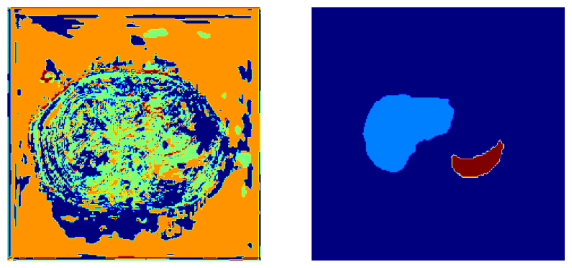

torch.Size([224, 224])

In [139]:
random_idx = torch.randint(0, len(train_dataset), size = [1,]).item()
image,mask = train_dataset[random_idx]
image = image.to(device)
pred = model(image.unsqueeze(dim = 0)).squeeze()
labels = pred.squeeze().argmax(dim = 0).detach()
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(labels.cpu(), cmap = "jet")
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(mask.squeeze(), cmap = "jet")
plt.axis(False)
plt.show()
labels.shape

In [140]:
def print_train_time(start, end, device=None):
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

In [141]:
n_channels = 1
n_classes = 5
model = SEUNet(n_channels,n_classes, bilinear = True).to(device)
# model = nn.DataParallel(model)
# model = SESegNet(in_chn = 1,out_chn = 5).to(device)
class_weights = torch.tensor([0.05,0.05,0.3,0.3,0.3]).to(device)
loss_fn = CrossEntropyDiceLoss(num_classes = n_classes, weight_ce = None)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 4, gamma = 0.9)

In [142]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                init.constant_(m.bias, 0)

initialize_weights(model)

In [144]:
BATCH_SIZE = 7
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last = False)
len(train_dataloader), len(val_dataloader)

(80, 9)

In [145]:
num_epochs = 30
train_start = timer()
train_loss_vec = []
val_loss_vec = []
epoch_vec = []
for epoch in tqdm(range(num_epochs)):
    print(f"Epoch {epoch}\n-----------")
    model.train()
    train_loss = 0
    for i,(img,mask) in enumerate(train_dataloader):
        if i%10 == 0:
            print(f"Train Mini-batch {i}")
        img,mask = img.to(device), mask.long().to(device)
        pred = model(img)
        loss = loss_fn(pred,mask.squeeze())
        train_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss/=len(train_dataloader)
    train_loss_vec.append(train_loss.detach().cpu())
    epoch_vec.append(epoch)
    
    val_loss = 0
    model.eval()
    with torch.inference_mode():
        for i,(val_img, val_mask) in enumerate(val_dataloader):
            if i%10==0:
                print(f"Validation Mini-batch {i}")
            val_img,val_mask = val_img.to(device), val_mask.long().to(device)
            val_pred = model(val_img)
            val_loss_step = loss_fn(val_pred,val_mask.squeeze())
            val_loss += val_loss_step
                
        val_loss/=len(val_dataloader)
        val_loss_vec.append(val_loss.cpu())

    # scheduler.step()
    print(f"Training Loss = {train_loss:.4f} | Validation Loss = {val_loss:.4f}")

train_stop = timer()
time_taken = print_train_time(train_start, train_stop, device = device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0
-----------
Train Mini-batch 0
Train Mini-batch 10
Train Mini-batch 20
Train Mini-batch 30
Train Mini-batch 40
Train Mini-batch 50
Train Mini-batch 60
Train Mini-batch 70
Validation Mini-batch 0
Training Loss = 1.3093 | Validation Loss = 0.9485
Epoch 1
-----------
Train Mini-batch 0
Train Mini-batch 10
Train Mini-batch 20
Train Mini-batch 30
Train Mini-batch 40
Train Mini-batch 50
Train Mini-batch 60
Train Mini-batch 70
Validation Mini-batch 0
Training Loss = 0.7193 | Validation Loss = 0.7323
Epoch 2
-----------
Train Mini-batch 0
Train Mini-batch 10
Train Mini-batch 20
Train Mini-batch 30
Train Mini-batch 40
Train Mini-batch 50
Train Mini-batch 60
Train Mini-batch 70
Validation Mini-batch 0
Training Loss = 0.4908 | Validation Loss = 0.6342
Epoch 3
-----------
Train Mini-batch 0
Train Mini-batch 10
Train Mini-batch 20
Train Mini-batch 30
Train Mini-batch 40
Train Mini-batch 50
Train Mini-batch 60
Train Mini-batch 70
Validation Mini-batch 0
Training Loss = 0.3601 | Validation Lo

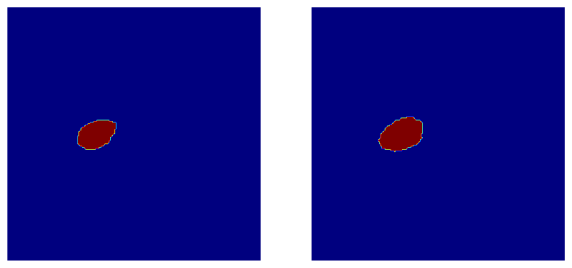

torch.Size([224, 224])

In [146]:
random_idx = torch.randint(0, len(train_dataset), size = [1,]).item()
image,mask = train_dataset[random_idx]
image = image.to(device)
pred = model(image.unsqueeze(dim = 0)).squeeze()
labels = pred.squeeze().argmax(dim = 0).detach()
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(labels.cpu(), cmap = "jet")
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(mask.squeeze(), cmap = "jet")
plt.axis(False)
plt.show()
labels.shape

In [147]:
def print_loss_curves(train_loss_vec,val_loss_vec,epoch_vec):
    plt.figure()
    plt.plot(train_loss_vec,label = "training loss")
    plt.plot(val_loss_vec,label = "validation loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

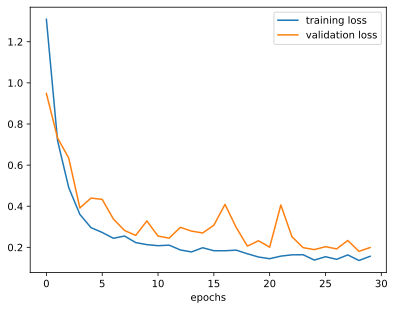

In [148]:
print_loss_curves(train_loss_vec,val_loss_vec,epoch_vec)

In [158]:
num_classes = 5
jaccard_scores = compute_average_jaccard_coefficient(model, train_dataset, num_classes)
print(jaccard_scores)
jaccard_avg = np.mean(jaccard_scores[1:])
print(jaccard_avg)

  0%|          | 0/560 [00:00<?, ?it/s]

[0.99288506 0.68985732 0.6630986  0.69247164 0.82001519]
0.7163606892573482


In [151]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)
MODEL_NAME = "mr_unet.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
# torch.save(model.state_dict(), MODEL_SAVE_PATH)

In [152]:
non_se_model = UNet(n_channels = 1,n_classes = 5,bilinear = True).to(device)
# non_se_model = SegNet(in_chn = 1,out_chn = 5).to(device)
non_se_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [153]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)
MODEL_NAME = "mr_seunet.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
# torch.save(model.state_dict(), MODEL_SAVE_PATH)

In [154]:
se_model = SEUNet(n_channels = 1,n_classes = 5,bilinear = True).to(device)
# se_model = SESegNet(in_chn = 1,out_chn = 5).to(device)
se_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [157]:
num_classes = 5
se_jaccard_scores = compute_average_jaccard_coefficient(se_model, train_dataset, num_classes)
print(se_jaccard_scores)
se_jaccard_avg = np.mean(se_jaccard_scores[1:])
print(se_jaccard_avg)

  0%|          | 0/560 [00:00<?, ?it/s]

[0.99351769 0.72894081 0.67299997 0.71199985 0.91425291]
0.7570483847696512


In [181]:
num_classes = 5
non_se_jaccard_scores = compute_average_jaccard_coefficient(non_se_model, val_dataset, num_classes)
print(non_se_jaccard_scores)
non_se_jaccard_avg = np.mean(non_se_jaccard_scores[1:])
print(non_se_jaccard_avg)

  0%|          | 0/63 [00:00<?, ?it/s]

[0.98965265 0.73154218 0.55980186 0.62983856 0.81085178]
0.6830085923253555


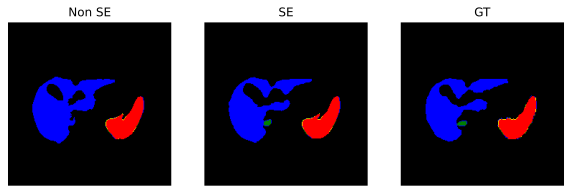

torch.Size([224, 224])

In [661]:
random_idx = torch.randint(0, len(train_dataset), size = [1,]).item()
image,mask = train_dataset[random_idx]
image = image.to(device)
pred_non_se = non_se_model(image.unsqueeze(dim = 0)).squeeze()
pred_se = se_model(image.unsqueeze(dim = 0)).squeeze()
labels_non_se = pred_non_se.squeeze().argmax(dim = 0).detach()
labels_se = pred_se.squeeze().argmax(dim = 0).detach()
plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(labels_non_se.cpu(), cmap = cmap)
plt.title("Non SE")
plt.axis(False)
plt.subplot(1,3,2)
plt.imshow(labels_se.cpu(), cmap = cmap)
plt.title("SE")
plt.axis(False)
plt.subplot(1,3,3)
plt.imshow(mask.squeeze(), cmap = cmap)
plt.title("GT")
plt.axis(False)
plt.show()
labels.shape